# This notebook creates training data for the FiD Reader module using the MSMARCO medical triples and MedQA queries + answers + options

### Look at data structure needed for training FiD

Each data point should be in the structure of a dict with these indices:
- question: the query. Is a string
- answers: corresponds to the options in MedQA. Is a list of strings, of unspecified dimension
- target: corresponds to the correct answer in MedQA. Is a string
- ctxs: is a list containing passage information:
    - id: the unique pid
    - title: passage title
    - text: the passage itself


In [1]:
import pandas as pd
import json

In [2]:
data_path = "/scratch/s190619/MSMARCO/FiD/FiD/open_domain_data/TQA/"
data_file = "train.json"
with open(data_path + data_file) as json_file:
    data = json.load(json_file)

In [3]:
data[0]

{'question': 'Who was President when the first Peanuts cartoon was published?',
 'answers': ['Presidency of Harry S. Truman',
  'Hary truman',
  'Harry Shipp Truman',
  "Harry Truman's",
  'Harry S. Truman',
  'Harry S.Truman',
  'Harry S Truman',
  'H. S. Truman',
  'President Harry Truman',
  'Truman administration',
  'Presidency of Harry Truman',
  'Mr. Citizen',
  'HST (president)',
  'H.S. Truman',
  'Mary Jane Truman',
  'Harry Shippe Truman',
  'S truman',
  'Harry Truman',
  'President Truman',
  '33rd President of the United States',
  'Truman Administration',
  'Harry Solomon Truman',
  'Harold Truman',
  'Harry truman',
  'H. Truman'],
 'target': 'Harry Truman',
 'ctxs': [{'id': '525783',
   'title': 'Peanuts',
   'text': 'the entire life of the Sunday strip. Most of the other characters that eventually became the main characters of Peanuts did not appear until later: Violet (February 1951), Schroeder (May 1951), Lucy (March 1952), Linus (September 1952), Pig-Pen (July 1954

### Load FZ corpus data

In [4]:
FZ_passages_path = "/scratch/s190619/MSMARCO/Data/FindZebra/" + "collection_FZ_w_titles.tsv"
df_FZ = pd.read_csv(FZ_passages_path, encoding="utf8", sep="\t", header=None, names=["pid","title","passage"])

In [5]:
df_FZ.head()

,pid,title,passage
0,0,Kernicterus,Kernicterusrefers to brain damage that may occ...
1,1,47 XXX syndrome,"47 XXX syndrome, also called trisomy X or trip..."
2,2,Pseudoxanthoma elasticum,"Pseudoxanthoma elasticum, PXE, is an inherited..."
3,3,Smith-Magenis Syndrome,SummaryClinical characteristics.Smith-Magenis ...
4,4,Smith-Lemli-Opitz Syndrome,SummaryClinical characteristics.Smith-Lemli-Op...


### Load ColBERT retrievals
This is probably not needed for training data

In [6]:
retrievals_path = "/scratch/s190619/MSMARCO/Retrievals/dev-test/" + "Ranking_Model1.tsv"
df_retrievals = pd.read_csv(retrievals_path, encoding="utf8", sep="\t", header=None, names=["qid","pid","rank"])

In [7]:
df_retrievals.head()
#df_retrievals["qid"].unique()

,qid,pid,rank
0,0,1724,1
1,0,15978,2
2,0,2624,3
3,0,16332,4
4,0,21257,5


### Load MedQA queries

In [8]:
# MedQA_path = "/scratch/s190619/MSMARCO/MedQA_US/" + "MedQAQueries_disorders_full_v2.csv"
# df_medQA = pd.read_csv(MedQA_path, sep=',', encoding="utf8", index_col=0)
queries_path = "/scratch/s190619/MSMARCO/Data/" + "retrieval_queries_dev-test.tsv"
df_queries = pd.read_csv(queries_path, sep='\t', encoding="utf8", header=None, names=["qid", "query"])

In [9]:
df_queries.head()

,qid,query
0,0,A 5-year-old girl is brought to the emergency ...
1,1,A 19-year-old boy presents with confusion and ...
2,2,A 41-year-old woman presents to her primary ca...
3,3,A 56-year-old man with known coronary artery d...
4,4,A 16-year-old female high school student is br...


### Load detailed MedQA queries with METAMAP CUIs

In [10]:
MedQA_path = "/scratch/s190619/MSMARCO/Data/" + "disorders_table_dev-test.csv"
df_medQA = pd.read_csv(MedQA_path, sep=',', encoding="utf8")#, header=None, names=["qid", "query"])

In [11]:
df_medQA.head()

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,0,A 5-year-old girl is brought to the emergency ...,Cyclic vomiting syndrome,"{'A': 'Cyclic vomiting syndrome', 'B': 'Gastro...",step2&3,True,NaN,NaN,NaN,NaN,NaN,['C0152164']
1,1,A 19-year-old boy presents with confusion and ...,Hypoperfusion,"{'A': 'Hypoperfusion', 'B': 'Hyperglycemia', '...",step1,True,C0442856,T046,DISO,Disorders,Pathologic Function,['C0442856']
2,2,A 41-year-old woman presents to her primary ca...,Iron deficiency,"{'A': 'Vitamin B12 deficiency', 'B': 'Folate d...",step2&3,True,C0240066,T047,DISO,Disorders,Disease or Syndrome,['C0240066']
3,3,A 56-year-old man with known coronary artery d...,Monomorphic ventricular tachycardia,"{'A': 'Premature ventricular contractions', 'B...",step1,True,NaN,NaN,NaN,NaN,NaN,['C0344431']
4,4,A 16-year-old female high school student is br...,Oppositional defiant disorder,"{'A': 'Reactive attachment disorder', 'B': 'Co...",step2&3,True,C0029121,T048,DISO,Disorders,Mental or Behavioral Dysfunction,['C0029121']


# Processing

In [12]:
from tqdm.notebook import tqdm
import ast

### MSMARCO medical data processing

In [3]:
from pyspark.sql.functions import countDistinct

In [4]:
# Create pyspark session
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

from pyspark.sql.types import *

schema = StructType([
    StructField("query", StringType()),
    StructField("positive_doc", StringType()),
    StructField("negative_doc", StringType())])


In [7]:
msmarco_medical_path = "/scratch/s190619/Data_etc/Medical_MSMARCO/triples.msmarco.medical.tsv"
MSM_M = spark.read.format('csv').options(header='false',multiline=True,delimiter='\t',encoding='utf-8').schema(schema).load(msmarco_medical_path)
MSM_M.limit(10).toPandas().head()

,query,positive_doc,negative_doc
0,is a little caffeine ok during pregnancy,We don’t know a lot about the effects of caffe...,It is generally safe for pregnant women to eat...
1,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,...","However, you still need some niacin each day; ..."
2,cancer of the pancreas symptoms,Symptoms of Pancreatic Cancer. Pancreatic canc...,Pancreatic cancer develops as abnormal pancrea...
3,what is the genus of the weeping willow tree,The weeping willow belongs to the Salix genus....,"The kola nut is the fruit of the kola tree, a ..."
4,can polycythemia cause stroke,Polycythemia Vera Complications. If you have P...,Stroke Recovery. Stroke affects everybody diff...


In [25]:
# %%time
# # MSM_M.filter(MSM_M["query"] == "is a little caffeine ok during pregnancy").count()
# MSM_M.select(countDistinct("positive_doc")).show()

+----------------------------+
|count(DISTINCT positive_doc)|
+----------------------------+
|                       40102|
+----------------------------+

CPU times: user 46.4 ms, sys: 17.5 ms, total: 63.9 ms
Wall time: 4min 31s


In [28]:
%%time
ms_docs = MSM_M.select('positive_doc').distinct().collect()

CPU times: user 298 ms, sys: 108 ms, total: 407 ms
Wall time: 4min 47s


In [8]:
%%time
# I think that there are a lot more distinct docs in the negatives, and they might not be related to a medical domain. I will just use the positives

# %%time
# ms_docs_neg = MSM_M.select('negative_doc').distinct().collect()
MSM_M.select(countDistinct("negative_doc")).show()

+----------------------------+
|count(DISTINCT negative_doc)|
+----------------------------+
|                     4839712|
+----------------------------+



In [9]:
%%time
MSM_M.select("negative_doc").distinct().coalesce(1).write.csv("/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs_neg.csv")

CPU times: user 71.5 ms, sys: 22.5 ms, total: 94 ms
Wall time: 7min 34s


In [29]:
ms_docs_cl = [x.asDict()["positive_doc"] for x in ms_docs]
f=open('/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs.txt','w')
for doc in ms_docs_cl:
    f.write(doc+'\n')

In [30]:
ms_docs_cl = []
f=open('/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs.txt','r')
for doc in f:
    ms_docs_cl.append(doc)

In [17]:
schema2 = StructType([StructField("negative_doc", StringType())])

MSM_M_neg = spark.read.format('csv').options(header='false',multiline=True,delimiter=',',encoding='utf-8').schema(schema2)\
             .load("/scratch/s190619/Data_etc/Medical_MSMARCO/MSMARCO_medical_docs_neg.csv")


In [24]:
[print(x.asDict()["negative_doc"]+"\n") for x in list(MSM_M_neg.sample(0.00001).limit(10).collect())]

Contemporary definitions for zafu. noun. a round thick cushion for sitting meditation, sometimes used on top of a mat. Examples. The zafu is ideal for lotus, half-lotus or Burmese style sitting meditation or other postures with your knees down on the zabuton mat. a round thick cushion for sitting meditation, sometimes used on top of a mat.

Virginia Open. The Virginia Open is the Virginia state open golf tournament, open to both amateur and professional golfers. It is organized by the Virginia State Golf Association and the Middle Atlantic section of the PGA of America. It has been played annually since 1924 (except for war years) at a variety of courses around the state.

Create or modify tables or indexes by using a data-definition query. You can create and modify tables, constraints, indexes and relationships by writing data-definition queries in SQL view. This article explains data-definition queries and how to use them to create tables, constraints, indexes, and relationships.

Sw

[None, None, None, None, None, None, None, None, None, None]

### Functions

In [37]:
from random import sample
from rank_bm25 import BM25Okapi
import json

In [38]:
def reader_data_from_ColBERT_retrievals(medQA, retrievals, FZ, topk = 100):
    assert retrievals[retrievals["qid"] == retrievals.loc[0,"qid"]].shape[0] >= topk
    
    FZ = FZ.set_index('pid')
    
    rdata = []
    error_qids = []
    for i in tqdm(range(medQA.shape[0])):
#     for i in tqdm(range(5)):
        qid = medQA["qid"].iloc[i]
        try:
            rdata_i = {}

            query = medQA["query"].iloc[i]
            answers = list(ast.literal_eval(medQA["options"].iloc[i]).values())
            target = medQA["answer"].iloc[i]
            rdata_i["question"] = query
            rdata_i["answers"] = answers
            rdata_i["target"] = target

            retrievals_tmp = retrievals[retrievals["qid"] == qid]
            retrievals_tmp = retrievals_tmp.join(FZ, on='pid').reset_index()
    #         print(retrievals_tmp.head())
    #         print(retrievals_tmp.tail())
    #         print(retrievals_tmp.shape)
            passage_list = []
            for j in range(topk):
                passages = {}
                passages['id'] = int(retrievals_tmp["pid"].iloc[j])
                passages['title'] = retrievals_tmp["title"].iloc[j]
                passages['text'] = retrievals_tmp["passage"].iloc[j]
                passage_list.append(passages)
            rdata_i["ctxs"] = passage_list

            rdata.append(rdata_i)
        except:
            error_qids.append(qid)
    
    return rdata, error_qids

In [54]:
def HRR(query, answer, ms_docs_cl, N):
    answer = answer.lower()
    corpus = [x for x in ms_docs_cl if answer in x]
    if len(corpus) > 0:
        tokenized_corpus = [doc.lower().replace("\n","").split(" ") for doc in corpus]
        bm25 = BM25Okapi(tokenized_corpus)
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        #N = min(len(doc_scores[np.where(doc_scores>doc_scores.max()/2)]),10)
        relevant_passages = bm25.get_top_n(tokenized_query, corpus, n=N)
        return relevant_passages
    else:
        return ["Not found"]

In [40]:
#df_medQA ms_docs_cl

def create_reader_train(df_medQA, ms_docs_cl, title_opt=3, N=10):
        #title_opt = 3 # Title opt defines how the title should be generated. Can take values = [1,2,3]

        reader_data = []
        notfound = []

        assert title_opt in [1,2,3], "Incorrect title option"

        #df_medQA2 = df_medQA[~df_medQA["answer"].isin(['1','2','3','4','5','A','B','C','D','E'])]

        for i in tqdm(range(df_medQA.shape[0])):
            if len(df_medQA["answer"].iloc[i]) < 3:
                continue
            tmp = {}
            tmp["question"] = df_medQA["query"].iloc[i]
            tmp["answers"] = list(ast.literal_eval(df_medQA["options"].iloc[i]).values())
            tmp["target"] = df_medQA["answer"].iloc[i]

            if title_opt == 1:
                title = ""
            elif title_opt == 2:
                title = ' '.join(tmp["answers"])
            elif title_opt == 3:
                title = ' '.join(sample(tmp["answers"],3))

            docs = HRR(tmp["question"], tmp["target"], ms_docs_cl, N)
            if docs[0] == "Not found":
                notfound.append(tmp["question"])
                continue

            tmp_list = []
            for i in range(len(docs)):
                tmp2 = {}
                tmp2["title"] = title
                tmp2["text"] = docs[i]
                tmp_list.append(tmp2)

            tmp["ctxs"] = tmp_list

            reader_data.append(tmp)

        return reader_data, notfound

In [139]:
for title_opt in tqdm([1,2,3]):
    reader_data, not_found = create_reader_train(df_medQA, ms_docs_cl, title_opt, N=10)
    
    path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_msmarco_medical_title" + str(title_opt) + ".json"
    
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(reader_data, f, ensure_ascii=False, indent=4)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

In [145]:
path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_msmarco_medical_title" + str(1) + ".json"
with open(path) as json_file:
    data_test = json.load(json_file)

In [133]:
len(reader_data)

329

In [134]:
num_of_docs_per_query = {}
for i in range(10):
    num_of_docs_per_query[i+1] = 0

for i in range(len(reader_data)):
    num_of_docs_per_query[len(reader_data[i]["ctxs"])] += 1

In [135]:
num_of_docs_per_query

{1: 77, 2: 42, 3: 22, 4: 33, 5: 19, 6: 13, 7: 9, 8: 12, 9: 9, 10: 93}

In [44]:
import matplotlib.pyplot as plt

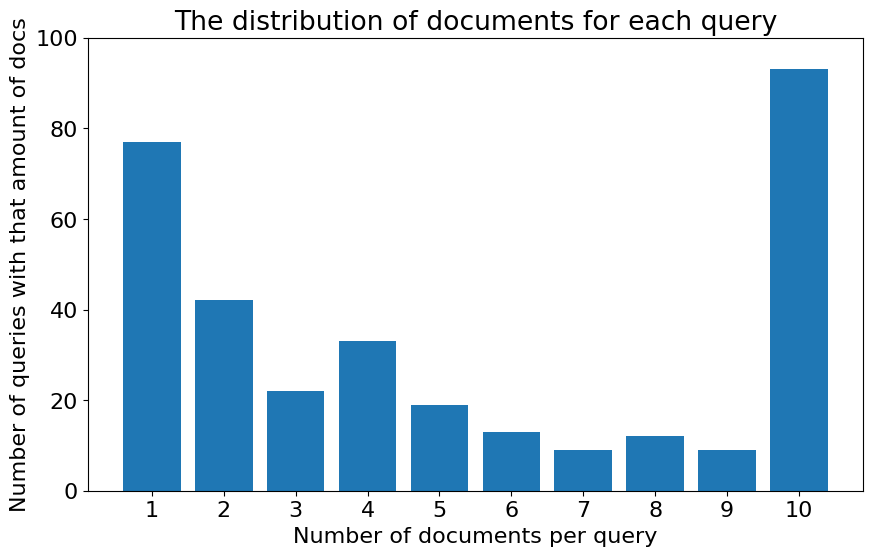

In [137]:
D = num_of_docs_per_query

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.yticks([0,20,40,60,80,100])

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100,'font.size': 16})
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.title("The distribution of documents for each query")
plt.ylabel("Number of queries with that amount of docs")
plt.xlabel("Number of documents per query")

plt.show()

In [15]:
rdata, errors = reader_data_from_ColBERT_retrievals(df_medQA, df_retrievals, df_FZ, topk=100)

  0%|          | 0/611 [00:00<?, ?it/s]

In [147]:
save_file_path = "/scratch/s190619/MSMARCO/Data/FindZebra/FiD_reader_data/Model1_retrieved_f_reader.json"
with open(save_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(rdata, outfile, ensure_ascii=False)

In [148]:
with open(save_file_path) as json_file:
    data_test = json.load(json_file)

In [161]:
index = 100
print(df_medQA["qid"].iloc[index])
print(df_medQA["query"].iloc[index])
print(df_medQA["answer"].iloc[index])
print(df_medQA["options"].iloc[index])

100
A 67-year-old woman with a recently found hepatic carcinoma has been an inpatient for more than a week. During morning rounds, she was abnormally disoriented to time and place along with a shortened attention span. The overnight resident reports that she was coming in and out of this state for the past couple nights. The patient was known to drink often, but reported that she has not consumed alcohol in weeks leading up to her admission. She is not jaundiced and has no metabolic imbalance upon laboratory tests. What is the most likely cause of her recent mental impairment?
Delirium
{'A': 'Delirium', 'B': 'Substance abuse', 'C': 'Brain metastasis', 'D': 'Delirium tremens', 'E': 'Dementia'}


In [10]:
#!python FiD_reader_format.py /scratch/s190619/MSMARCO/Data/FindZebra/collection_FZ_w_titles.tsv /scratch/s190619/MSMARCO/Retrievals/dev-test/Ranking_Model1.tsv /scratch/s190619/MSMARCO/Data/disorders_table_dev-test.csv /scratch/s190619/MSMARCO/Data/FindZebra/FiD_reader_data/test.json

# MedQA textbook

In [32]:
source = "/scratch/s190619/MSMARCO/MedQA_US/textbooks/combined_text_books.txt"

textbooks = []
f = open(source, "r")
for x in f:
    textbooks.append(x)
f.close()

TB = [x.replace("\n","") for x in textbooks if x != "\n"]
TB_l = [x.lower() for x in TB]
TB_m = [x for x in TB_l if len(x) > 100 and len(x) < 2000]

In [16]:
df_medQA.head()

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,0,A 5-year-old girl is brought to the emergency ...,Cyclic vomiting syndrome,"{'A': 'Cyclic vomiting syndrome', 'B': 'Gastro...",step2&3,True,NaN,NaN,NaN,NaN,NaN,['C0152164']
1,1,A 19-year-old boy presents with confusion and ...,Hypoperfusion,"{'A': 'Hypoperfusion', 'B': 'Hyperglycemia', '...",step1,True,C0442856,T046,DISO,Disorders,Pathologic Function,['C0442856']
2,2,A 41-year-old woman presents to her primary ca...,Iron deficiency,"{'A': 'Vitamin B12 deficiency', 'B': 'Folate d...",step2&3,True,C0240066,T047,DISO,Disorders,Disease or Syndrome,['C0240066']
3,3,A 56-year-old man with known coronary artery d...,Monomorphic ventricular tachycardia,"{'A': 'Premature ventricular contractions', 'B...",step1,True,NaN,NaN,NaN,NaN,NaN,['C0344431']
4,4,A 16-year-old female high school student is br...,Oppositional defiant disorder,"{'A': 'Reactive attachment disorder', 'B': 'Co...",step2&3,True,C0029121,T048,DISO,Disorders,Mental or Behavioral Dysfunction,['C0029121']


In [55]:
for title_opt in tqdm([1,2,3]):
    reader_data, not_found = create_reader_train(df_medQA, TB_m, title_opt, N=10)
    
    path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_medQA_title" + str(title_opt) + ".json"
    
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(reader_data, f, ensure_ascii=False, indent=4)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

In [56]:
path = "/scratch/s190619/Data_etc/Medical_MSMARCO/FiD_train/" + "FiD_train_medQA_title" + str(1) + ".json"
with open(path) as json_file:
    data_test = json.load(json_file)

In [57]:
num_of_docs_per_query = {}
for i in range(10):
    num_of_docs_per_query[i+1] = 0

for i in range(len(reader_data)):
    num_of_docs_per_query[len(reader_data[i]["ctxs"])] += 1

In [58]:
num_of_docs_per_query

{1: 29, 2: 19, 3: 9, 4: 19, 5: 16, 6: 10, 7: 9, 8: 8, 9: 11, 10: 437}

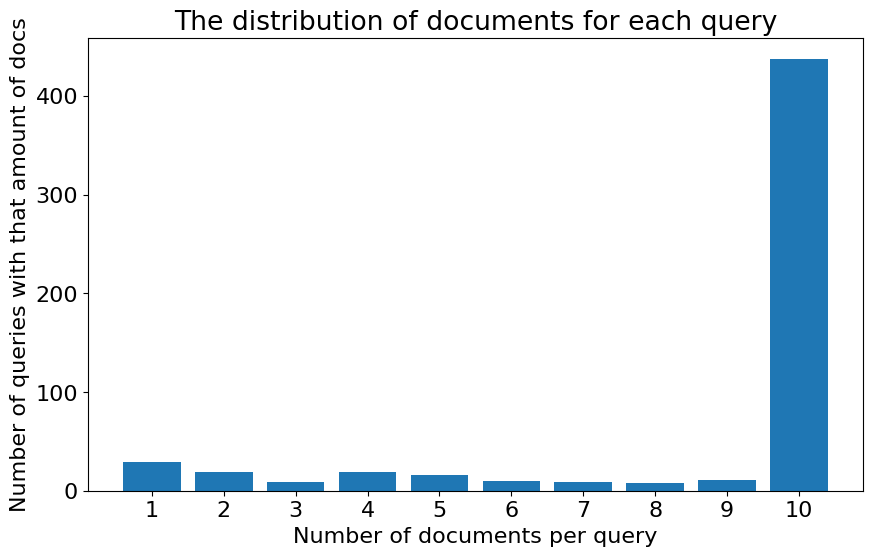

In [60]:
D = num_of_docs_per_query

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.yticks([0,20,40,60,80,100])

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100,'font.size': 16})
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.title("The distribution of documents for each query")
plt.ylabel("Number of queries with that amount of docs")
plt.xlabel("Number of documents per query")

plt.show()

In [70]:
df_fz = pd.read_csv("/scratch/s190619/MSMARCO/FZ_corpus_evaluation.tsv", sep="\t")

In [72]:
fz_cuis = df_fz["cui"].unique()

In [74]:
len(fz_cuis)

14966

In [75]:
df_medQA.head()

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,0,A 5-year-old girl is brought to the emergency ...,Cyclic vomiting syndrome,"{'A': 'Cyclic vomiting syndrome', 'B': 'Gastro...",step2&3,True,NaN,NaN,NaN,NaN,NaN,['C0152164']
1,1,A 19-year-old boy presents with confusion and ...,Hypoperfusion,"{'A': 'Hypoperfusion', 'B': 'Hyperglycemia', '...",step1,True,C0442856,T046,DISO,Disorders,Pathologic Function,['C0442856']
2,2,A 41-year-old woman presents to her primary ca...,Iron deficiency,"{'A': 'Vitamin B12 deficiency', 'B': 'Folate d...",step2&3,True,C0240066,T047,DISO,Disorders,Disease or Syndrome,['C0240066']
3,3,A 56-year-old man with known coronary artery d...,Monomorphic ventricular tachycardia,"{'A': 'Premature ventricular contractions', 'B...",step1,True,NaN,NaN,NaN,NaN,NaN,['C0344431']
4,4,A 16-year-old female high school student is br...,Oppositional defiant disorder,"{'A': 'Reactive attachment disorder', 'B': 'Co...",step2&3,True,C0029121,T048,DISO,Disorders,Mental or Behavioral Dysfunction,['C0029121']


In [76]:
df_medQA.shape

(611, 12)

In [79]:
counter = 0
for i in range(df_medQA.shape[0]):
    con = False
    cuis = ast.literal_eval(df_medQA["cui_METAMAP"].iloc[i])
    cuis.append(df_medQA["CUI"].iloc[i])
    for cui in cuis:
        if cui in fz_cuis:
            con = True
    if con == True:
        counter += 1

In [80]:
counter

394